In [8]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
no_of_sample = 1
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 64
w_img = 64
flat = h_img*w_img*3
train_losses = []

In [9]:
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()
dec_hi_cpu = torch.Tensor(w.dec_hi[::-1]).clone().cpu()
dec_lo_cpu = torch.Tensor(w.dec_lo[::-1]).clone().cpu()
rec_hi_cpu = torch.Tensor(w.rec_hi).clone().cpu()
rec_lo_cpu = torch.Tensor(w.rec_lo).clone().cpu()


filters = torch.stack([dec_lo_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_lo_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)


def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
#     print(vimg.size())
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, Variable(filters[:,None]),stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
        res[:,:1,32:,:] = res[:,:1,32:,:]*1.
        res[:,:1,:,32:] = res[:,:1,:,32:]*1.
        res[:,1:] = res[:,1:]*1.
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res



def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding
#     print(res.shape)
    return res

In [10]:
class CelebaDataset(Dataset):

    def __init__(self, root_dir, img_list, WT=False):
        self.root_dir = root_dir
        self.img_list = img_list
        self.WT = WT

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.img_list[idx]))
        img = np.array(img)
        img = img / 255
        img = torch.from_numpy(img.transpose(2,0,1)).float()
        
        # Returning both original image and WT image if self.WT
        if self.WT:
#             img_wt = torch.from_numpy(img.transpose(2,0,1)).float()
            img_wt = wt(img_wt.unsqueeze(1)).squeeze()

            return img, img_wt
        
        return img
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors. numpy image: H x W x C, torch image: C X H X W
    """

    def __call__(self, image, invert_arrays=True):

        if invert_arrays:
            image = image.transpose((2, 0, 1))[:,:h_img*2,:w_img*2]

        return torch.from_numpy(image)

0

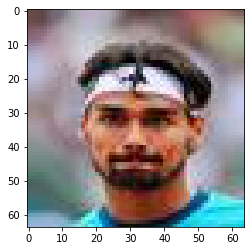

In [11]:
# Creating and testing dataset with WT & IWT
random.seed(2020)
root_dir = "celeba64/"
image_files = os.listdir(root_dir)

ds = CelebaDataset('celeba64/', image_files, WT=False)
ds_loader = DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)

# Show original img
t = ds[0]
plt.imshow(t.numpy().transpose((1,2,0)))

gc.collect()

In [12]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size=2048):
        return input.view(input.size(0), size, 1, 1)

class UnFlatten1(nn.Module):        
    def forward(self, input, size=3):
        return input.view(input.size(0), size, 32, 32)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=2048, z_dim=100):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # N * 32 * 31 * 31
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # N * 64 * 14 * 14,
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # N * 128 * 6 * 6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # N * 256 * 2 * 2
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=1, stride=1), # N * 512 * 2 * 2
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        # Decoder
        self.fct_decode_1 = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2), # N * 128 * 5 * 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2), # N * 64 * 13 * 13
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2), # N * 64 * 30 * 30
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2), # N * 3 * 64 * 64
            nn.Sigmoid(),
        )
        
        self.wt1 = nn.Sequential(
            nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
            nn.BatchNorm2d(image_channels)
        )
        
        self.wt2 = nn.Sequential(
            nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
            nn.BatchNorm2d(image_channels)
        )
        
#         self.wt3 = nn.Sequential(
#             nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
#             nn.BatchNorm2d(image_channels)
#         )
        

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            # return torch.normal(mu, std)
            esp = torch.randn(*mu.size()).cuda()
            z = mu + std * esp
            return z
        else:
            return mu
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.fct_decode_1(z)
        z = self.wt1(z)
        z = self.wt2(z)
#         z = self.wt3(z)
        
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
       
#         z_final = Variable(torch.stack([z_1,z_2,z_3,z_4], dim=1))
#         z_final = z_final.view(-1,2,128//2,128//2).transpose(1,2).contiguous().view(-1,1,128,128)

    def loss_function(self, wt_x, x, mu, logvar) -> Variable:
        
        wt_x = wt_x.view(-1,1,64,64)
        x_recon = iwt(wt_x, levels=3)
        x_recon = x_recon.view(-1,3,64,64)
        x_recon = x_recon.contiguous()
        
        # Loss btw reconstructed img and original img
        BCE = F.l1_loss(x_recon.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.0001
        KLD /= BATCH_SIZE * 3 * 64 * 64

        return BCE + KLD

In [13]:

def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data = data.cuda()

        optimizer.zero_grad()
        
        wt_batch, mu, logvar = model(data)
        loss = model.loss_function(wt_batch, data, mu, logvar)
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)
           

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))




In [14]:
train_dataset = CelebaDataset('celeba64/', image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)

In [19]:
# train_losses = []
# gc.collect()
# EPOCHS = 100
# model = VAE()
# if CUDA: 
#     print('CUDA = {}'.format(CUDA))
#     model.cuda()
#     x_sample = torch.randn(32,3,64,64).cuda()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# for epoch in range(1, EPOCHS + 1):
#     train(epoch, model, optimizer, train_loader)

#     # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
#     # digits in latent space
#     sample = Variable(torch.randn(32,100))
#     if CUDA:
#         sample = sample.cuda()
#     x_sample1 = model.decode(sample)
#     save_image(x_sample1[:8].cpu(), './image_samples/celeba-1/decoded_sample' + str(epoch) + '.png')  
    
#     x_sample1 = x_sample1.view(-1,1,64,64)
#     x_sample1 = iwt(x_sample1, levels=3)
#     x_sample1 = x_sample1.view(-1,3,64,64)
# #     x_sample1 /= torch.max(x_sample1)
    
#     x_sample1 = x_sample1.contiguous()
#     save_image(x_sample1[:8].cpu(), './image_samples/celeba-1/sample' + str(epoch) + '.png')  
    
#     torch.save(model.state_dict(), './models/wtvae64_models_rest0/wtvae_epoch{}.pth'.format(epoch))
    

    

CUDA = True
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.029711
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.018216
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.013986
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.012152
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.011245
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.011177
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.010416
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.010637
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.010055
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.010354
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.010283
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.010158
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.009363
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.009649
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.009457
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.009215
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.009020
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.009271
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.009788
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.008500
Train Epoch: 1 [3200/10

Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.005126
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.005150
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.004503
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.004930
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.004953
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.004917
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.005174
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.004753
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.004953
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.004991
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.004916
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.005063
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.005056
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.004526
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.004953
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.004996
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.004736
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.005102
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.004526
Train Epoch: 3 [9760/10000 (97%)]	Loss: 0.004954
Train Epoch: 3 [9920

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses)
plt.show()

In [ ]:
#model